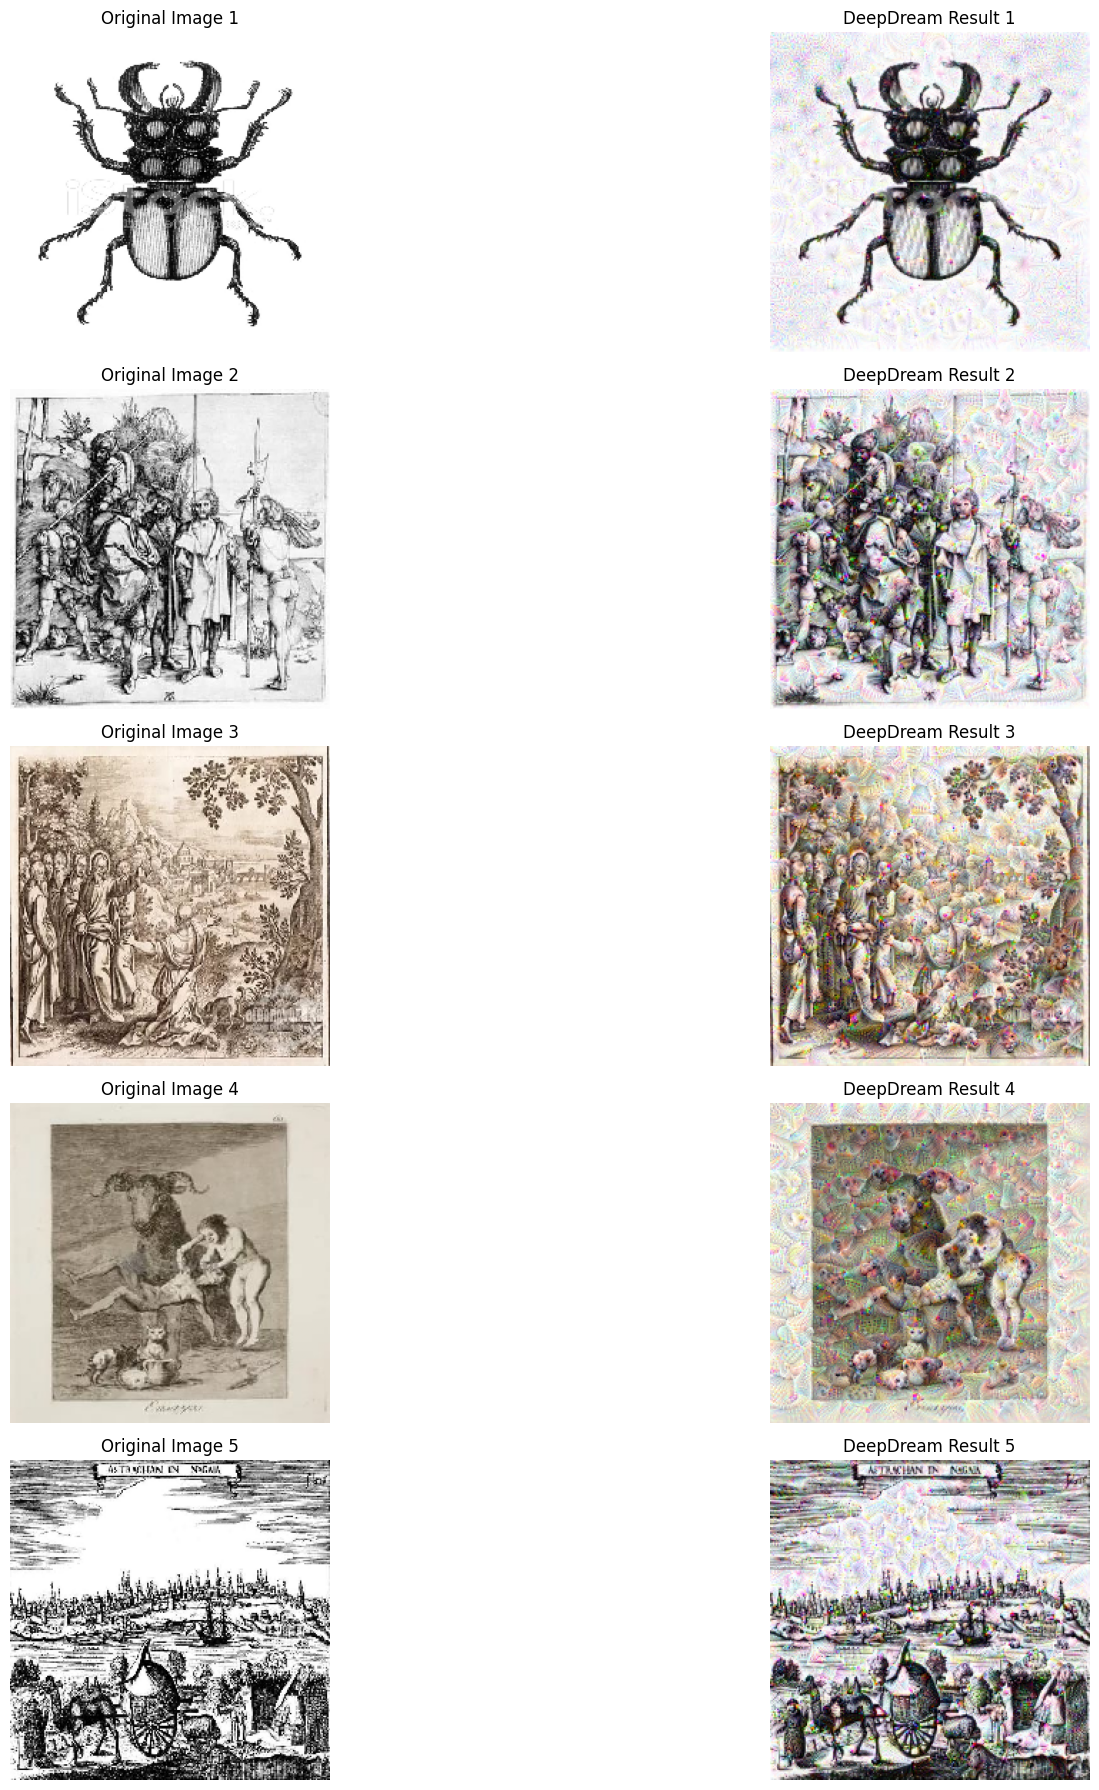

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the InceptionV3 model pre-trained on ImageNet
model = InceptionV3(include_top=False, weights='imagenet')
layer_names = ['mixed3', 'mixed5', 'mixed7']
layers = [model.get_layer(name).output for name in layer_names]
dream_model = tf.keras.Model(inputs=model.input, outputs=layers)

# Preprocess the image for the model
def preprocess_image(img_path, target_size=(299, 299)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return tf.convert_to_tensor(img)

# Apply gradient ascent on the image
def deepdream_step(model, img, step_size=0.01):
    with tf.GradientTape() as tape:
        tape.watch(img)
        outputs = model(img)
        loss = tf.reduce_mean([tf.reduce_mean(output) for output in outputs])
    gradients = tape.gradient(loss, img)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    img += step_size * gradients
    img = tf.clip_by_value(img, -1, 1)
    return img

# Run DeepDream on multiple octaves for finer details
def run_deepdream_with_octaves(model, img, steps_per_octave=50, step_size=0.01, octaves=3, octave_scale=1.4):
    for octave in range(octaves):
        if octave > 0:
            new_size = tf.convert_to_tensor(np.int32(np.array(img.shape[1:3]) * octave_scale))
            img = tf.image.resize(img, new_size)
        for step in range(steps_per_octave):
            img = deepdream_step(model, img, step_size)
    return img

# Directory containing engraving images
dataset_dir = '/home/atulrajput/Desktop/AR/My Projects/CVPR Projects/cvpr/Deep Dream Project/datasets/engraving_dataset/'  # Adjust this path

# Lists to store images for display
deepdream_images = []
original_images = []

# Process up to 5 images from the dataset
for i, filename in enumerate(os.listdir(dataset_dir)):
    if i >= 5:  # Limit to 5 images
        break
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(dataset_dir, filename)

        try:
            # Load and preprocess the image
            preprocessed_img = preprocess_image(image_path)

            # Run DeepDream on the image
            deepdream_result = run_deepdream_with_octaves(dream_model, preprocessed_img, steps_per_octave=50, step_size=0.01, octaves=3, octave_scale=1.4)

            # Convert the result to a displayable format
            result_img = tf.squeeze(deepdream_result)
            result_img = (result_img + 1) / 2  # Scale to [0, 1] for display
            result_img = tf.image.resize(result_img, (224, 224)).numpy()  # Resize for uniform display

            # Load and resize original image for comparison
            original_img = load_img(image_path, target_size=(224, 224))
            original_img_array = img_to_array(original_img) / 255.0  # Normalize

            # Append images for display
            deepdream_images.append(result_img)
            original_images.append(original_img_array)

        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Display the original and DeepDream images side by side
plt.figure(figsize=(20, 18))
for idx in range(len(deepdream_images)):
    # Original Image
    plt.subplot(len(deepdream_images), 2, 2*idx + 1)
    plt.imshow(original_images[idx])
    plt.axis('off')
    plt.title(f'Original Image {idx + 1}')

    # DeepDream Image
    plt.subplot(len(deepdream_images), 2, 2*idx + 2)
    plt.imshow(deepdream_images[idx])
    plt.axis('off')
    plt.title(f'DeepDream Result {idx + 1}')

plt.tight_layout()
plt.show()


In [3]:
# Existing code...

# After processing images...
import h5py

# Save the deepdream and original images
with h5py.File('/home/atulrajput/Desktop/AR/My Projects/CVPR Projects/cvpr/Deep Dream Project/engraving_data.h5', 'w') as hf:
    hf.create_dataset('deepdream_images', data=np.array(deepdream_images))
    hf.create_dataset('original_images', data=np.array(original_images))

# Display the original and DeepDream images as before
# ... (your plotting code)
